# I. Description l’ensemble du jeu de données


Le jeu de données utilisé provient de la plateforme [Kaggle](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data) et rassemble des informations sur des individus ayant effectué une demande de prêt. Il contient à la fois des **caractéristiques socio-démographiques** et **financières** des emprunteurs, ainsi que le **statut final du prêt**.

Le jeu comprend :

- Des **variables qualitatives** telles que le genre (`person_gender`), le niveau d’éducation (`person_education`), le type de logement (`person_home_ownership`), l’objectif du prêt (`loan_intent`), les défauts de paiement antérieurs (`previous_loan_defaults_on_file`) et le statut du prêt (`loan_status`)

- Des **variables quantitatives** comme l’âge (`person_age`), le revenu (`person_income`), le montant du prêt (`loan_amnt`) et le score de crédit (`credit_score`)

Ce jeu de données offre une vue d’ensemble riche et structurée sur les profils d’emprunteurs, à travers une diversité de variables à la fois catégorielles et numériques.


# II. Analyse univariée et bivariée

## 1. Analyse univariée

In [ ]:
# Loading the necessary libraries
suppressMessages(library(dplyr))
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(patchwork) 
library(gplots)
library(graphics)
library(mclust)
library(kernlab)
library(NMF)
summary(resBICall)
options(repr.plot.width = 10, repr.plot.height = 6)  # chỉ dùng được trong Jupyter hoặc R Markdown


In [2]:
loan <- read.csv("loan_data.csv")
summary(loan)

   person_age     person_gender      person_education   person_income    
 Min.   : 20.00   Length:45000       Length:45000       Min.   :   8000  
 1st Qu.: 24.00   Class :character   Class :character   1st Qu.:  47204  
 Median : 26.00   Mode  :character   Mode  :character   Median :  67048  
 Mean   : 27.76                                         Mean   :  80319  
 3rd Qu.: 30.00                                         3rd Qu.:  95789  
 Max.   :144.00                                         Max.   :7200766  
 person_emp_exp   person_home_ownership   loan_amnt     loan_intent       
 Min.   :  0.00   Length:45000          Min.   :  500   Length:45000      
 1st Qu.:  1.00   Class :character      1st Qu.: 5000   Class :character  
 Median :  4.00   Mode  :character      Median : 8000   Mode  :character  
 Mean   :  5.41                         Mean   : 9583                     
 3rd Qu.:  8.00                         3rd Qu.:12237                     
 Max.   :125.00                 

**Transformation des variables qualitatives en factor**: 

In [3]:
loan[, "person_gender"] <- as.factor(loan[, "person_gender"])
loan[, "person_education"] <- as.factor(loan[, "person_education"])
loan[, "person_home_ownership"] <- as.factor(loan[, "person_home_ownership"])
loan[, "loan_intent"] <- as.factor(loan[, "loan_intent"])
loan[, "previous_loan_defaults_on_file"] <- as.factor(loan[, "previous_loan_defaults_on_file"])
loan[, "loan_status"] <- as.factor(loan[, "loan_status"])

In [4]:
if (sum(is.na(loan)) != 0) print(sum(is.na(loan)))
dup_count <- sum(duplicated(loan))
if (dup_count != 0) print(dup_count)


**Détecter les valeurs extrêmes**

In [5]:
loan[loan$person_age > 100, ]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
,<dbl>,<fct>,<fct>,<dbl>,<int>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>
82,144,male,Bachelor,300616,125,RENT,4800,VENTURE,13.57,0.02,3,789,No,0
184,144,male,Associate,241424,121,MORTGAGE,6000,EDUCATION,11.86,0.02,2,807,No,0
576,123,female,High School,97140,101,RENT,20400,EDUCATION,10.25,0.21,3,805,Yes,0
748,123,male,Bachelor,94723,100,RENT,20000,VENTURE,11.01,0.21,4,714,Yes,0
32298,144,female,Associate,7200766,124,MORTGAGE,5000,PERSONAL,12.73,0.00,25,850,No,0
37931,116,male,Bachelor,5545545,93,MORTGAGE,3823,VENTURE,12.15,0.00,24,708,No,0
38114,109,male,High School,5556399,85,MORTGAGE,6195,VENTURE,12.58,0.00,22,792,No,0


In [6]:
# Personnes avec un âge > 100 ans
extreme_age <- loan[loan$person_age > 100, ]
# Voir combien de cas
nrow(extreme_age) #0.015% de loan
loan <- loan[loan$person_age <= 100, ]

[1] 7

In [7]:
nrow(loan[loan$person_age > 100, ])
nrow(loan[loan$person_emp_exp > 80, ])
nrow(loan[loan$person_income > 5000000, ])

[1] 0

[1] 0

[1] 0

**Étudier les distribution**

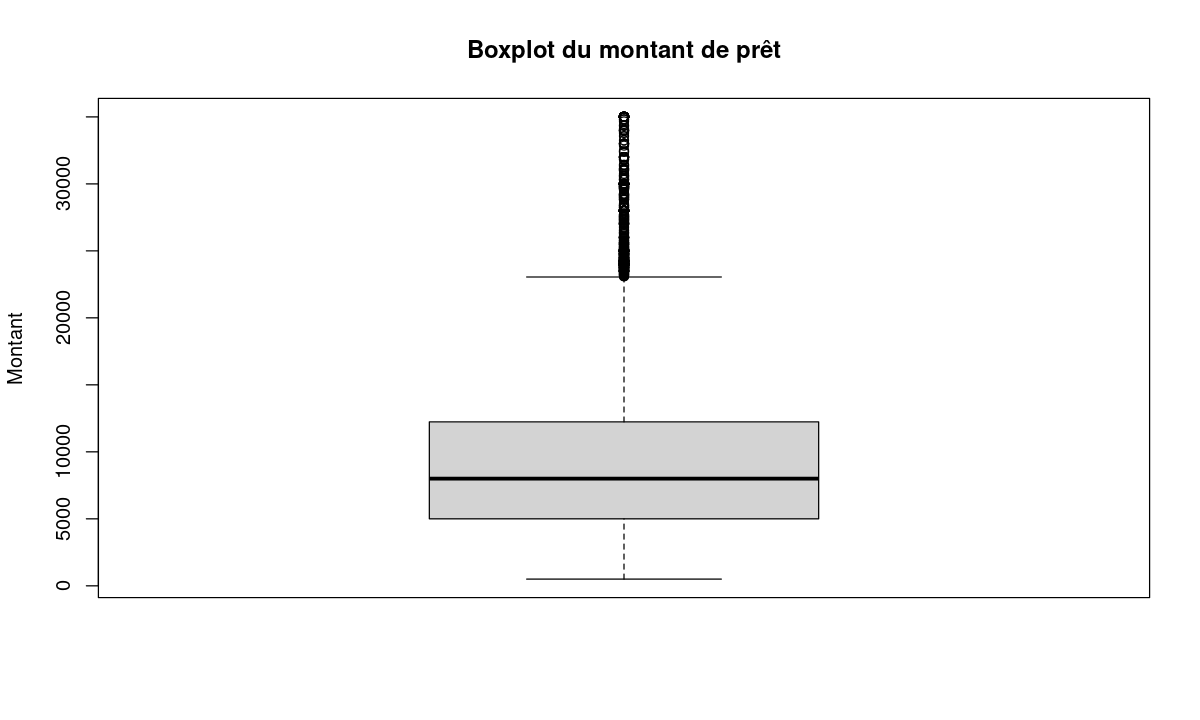

In [11]:
# Boîte à moustaches (boxplot)
boxplot(loan$loan_amnt, main = "Boxplot du montant de prêt", ylab = "Montant")

In [ ]:
ggplot(loan, aes(x = factor(loan_status))) +
  geom_bar() +
  labs(title = "Distribution des statuts de prêt", 
       x = "Statut (0 = Rejeté, 1 = Approuvé)", 
       y = "Nombre de demandes") +
  theme_minimal()

On remarque un nombre plus élevé de prêts rejetés que de prêts approuvés, ce qui peut indiquer un déséquilibre entre les classes

In [ ]:
# Sélectionner uniquement les colonnes numériques
numeric_vars <- names(loan)[sapply(loan, is.numeric)]

plots <- map(numeric_vars, function(var) {
  ggplot(loan, aes_string(x = var)) +
    geom_histogram(aes(y = ..density..), bins = 30, fill = "grey", color = "black", alpha = 0.6) +
    geom_density(alpha = 0.5, color = "blue") +
    ggtitle(paste("Distribution de", var)) +
    theme_minimal()
})

do.call(grid.arrange, c(plots, ncol = 2))

In [8]:
loan[, "person_income"] <- log(loan[, "person_income"])

## 2 Analyse bivariée

In [ ]:
p1 <- ggplot(loan, aes(x = factor(loan_status), y = loan_amnt)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Montant du prêt", x = "Statut du prêt", y = "Montant") +
  theme_minimal()

p2 <- ggplot(loan, aes(x = factor(loan_status), y = person_age)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Âge", x = "Statut du prêt", y = "Âge") +
  theme_minimal()

p3 <- ggplot(loan, aes(x = factor(loan_status), y = credit_score)) +
  geom_boxplot(fill = "lightblue") +
  labs(title = "Score de crédit", x = "Statut du prêt", y = "Score") +
  theme_minimal()

# Combine as subplot
(p1 | p2 | p3)  # 3 plots side by side 

In [ ]:
par(mfrow = c(2, 3)) 

mosaicplot(~ person_gender + loan_status, data = loan,
           main = "Genre vs Statut", col = TRUE)

mosaicplot(~ person_education + loan_status, data = loan,
           main = "Éducation vs Statut", col = TRUE)

mosaicplot(~ person_home_ownership + loan_status, data = loan,
           main = "Propriété logement vs Statut", col = TRUE)

mosaicplot(~ loan_intent + loan_status, data = loan,
           main = "Objet du prêt vs Statut", col = TRUE)

mosaicplot(~ previous_loan_defaults_on_file + loan_status, data = loan,
           main = "Prêts en défaut précédents vs Statut", col = TRUE)


Les candidats ayant des antécédents de défaut de paiement de prêt ont un taux de rejet nettement plus élevé que ceux qui n’ont pas connu de défaut de paiement.

In [ ]:


p1 <- ggplot(loan, aes(x = person_gender, y = credit_score, fill = person_gender)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le genre",
       x = "Genre", y = "Score de crédit") +
  theme_minimal()

p2 <- ggplot(loan, aes(x = person_education, y = credit_score, fill = person_education)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le niveau d'éducation",
       x = "Niveau d'éducation", y = "Score de crédit") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

p3 <- ggplot(loan, aes(x = person_home_ownership, y = credit_score, fill = person_home_ownership)) +
  geom_boxplot() +
  labs(title = "Score de crédit selon le type de logement",
       x = "Statut de logement", y = "Score de crédit") +
  theme_minimal()

# Combine side-by-side
grid.arrange(p1, p2, p3, ncol = 3)


In [9]:
loan_quanti <- loan[,c(1,4,5,7,9,10,11,12)]
loan_quali <- loan[,-c(1,4,5,7,9,10,11,12)]

In [ ]:

corrplot(cor(loan_quanti),method="ellipse", addCoef.col = "black")
boxplot(loan,outline = FALSE)
#ggpairs(loan_quanti)

In [ ]:
numerical_columns <- names(loan)[sapply(loan, is.numeric)]
plots <- lapply(numerical_columns, function(col_name) {
ggplot(loan, aes_string(x = col_name, fill = "factor(loan_status)")) +
  geom_density(alpha = 0.5) +
  labs(title = paste(col_name, "vs Loan Status"), x = col_name, y = "Density", fill = "Loan Status") +
  theme_minimal()
    
})

# Afficher en grille 4x2
do.call(grid.arrange, c(plots, ncol = 2))


# II Réduction linaire

## PCA

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,2.86205374,35.7756718,35.77567
comp 2,1.65218937,20.6523671,56.42804
comp 3,1.29964269,16.2455336,72.67357
comp 4,0.95620119,11.9525148,84.62609
comp 5,0.93872759,11.7340949,96.36018
comp 6,0.17441279,2.1801599,98.54034
comp 7,0.07326010,0.9157513,99.45609
comp 8,0.04351253,0.5439066,100.00000


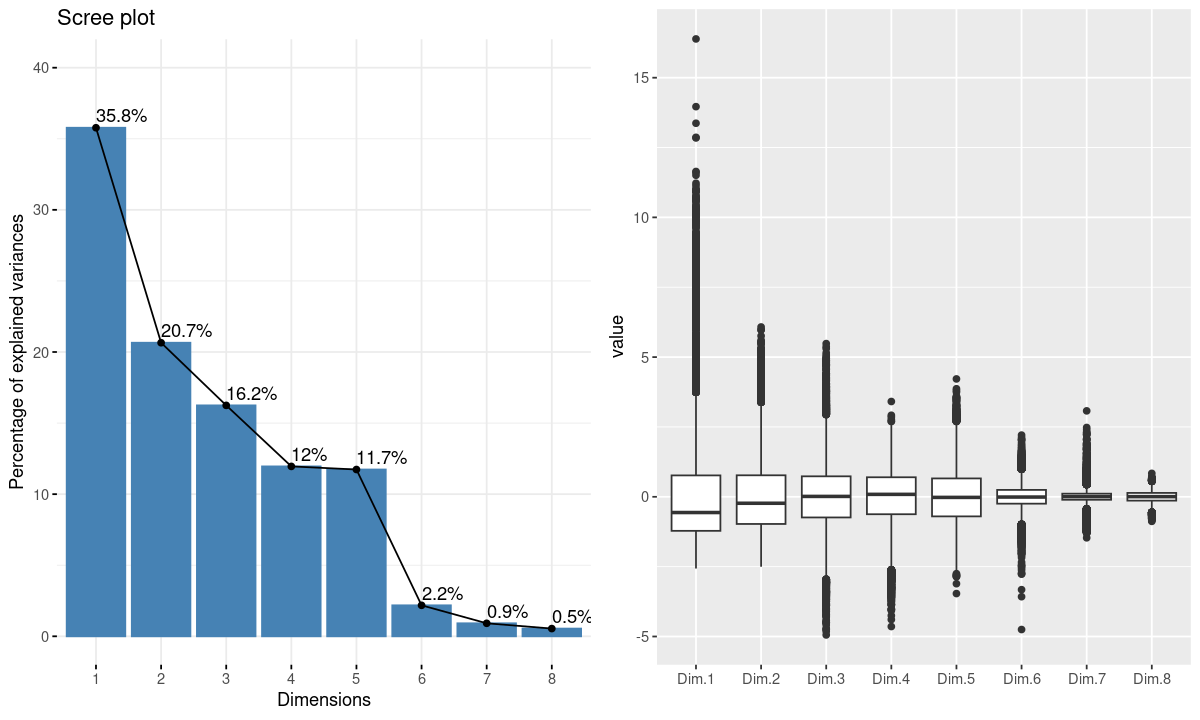

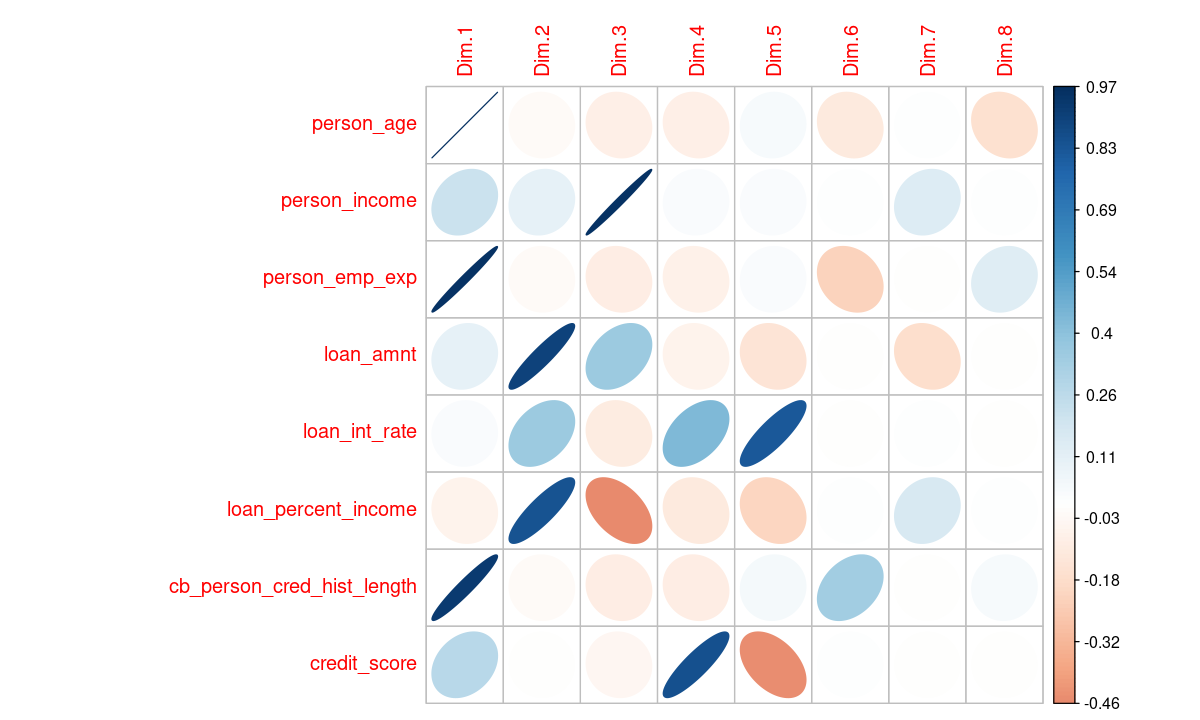

In [10]:
acp <- PCA(loan_quanti, scale.unit = TRUE,
           graph = FALSE,  ncp = 8)
# Eigenvalue decay
acp$eig
library(factoextra)
g1<-fviz_eig(acp, addlabels = TRUE, ylim = c(0, 40))
library(reshape2)
g2<-ggplot(melt(acp$ind$coord),aes(x=Var2,y=value))+
  geom_boxplot()+
  xlab("")
grid.arrange(g1,g2,ncol=2)


corrplot(acp$var$cor, is.corr=FALSE,method="ellipse")

In [ ]:
#fviz_pca_ind(acp,col.ind="contrib",label="none")
fviz_pca_ind(acp)
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ))
#fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
#fviz_pca_ind(acp, label="none", habillage=2)

In [ ]:
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(1,3))
fviz_pca_ind(acp,col.ind="contrib",label="none",gradient.cols = c("white", "#2E9FDF", "#FC4E07" ),axes=c(2,3))

In [ ]:
p1 <- fviz_pca_var(acp)                     # Dim 1 & 2
p2 <- fviz_pca_var(acp, axes = c(1, 3))     # Dim 1 & 3
p3 <- fviz_pca_var(acp, axes = c(2, 3))     # Dim 2 & 3

# Combine the plots in one row
grid.arrange(p1, p2, p3, ncol = 3)

#fviz_pca_var(acp,axes =c(1,4))
#fviz_pca_var(acp,axes =c(2,4))
#fviz_pca_var(acp,axes =c(3,4))

Dim1: person_age, person_emp_exp, cb_person_cred_hist_length 
Dim2: loan_amnt, loan_percent_income 
Dim3: person_income 
Dim4: credit score

# MCA

# Étude des variable qualitatives

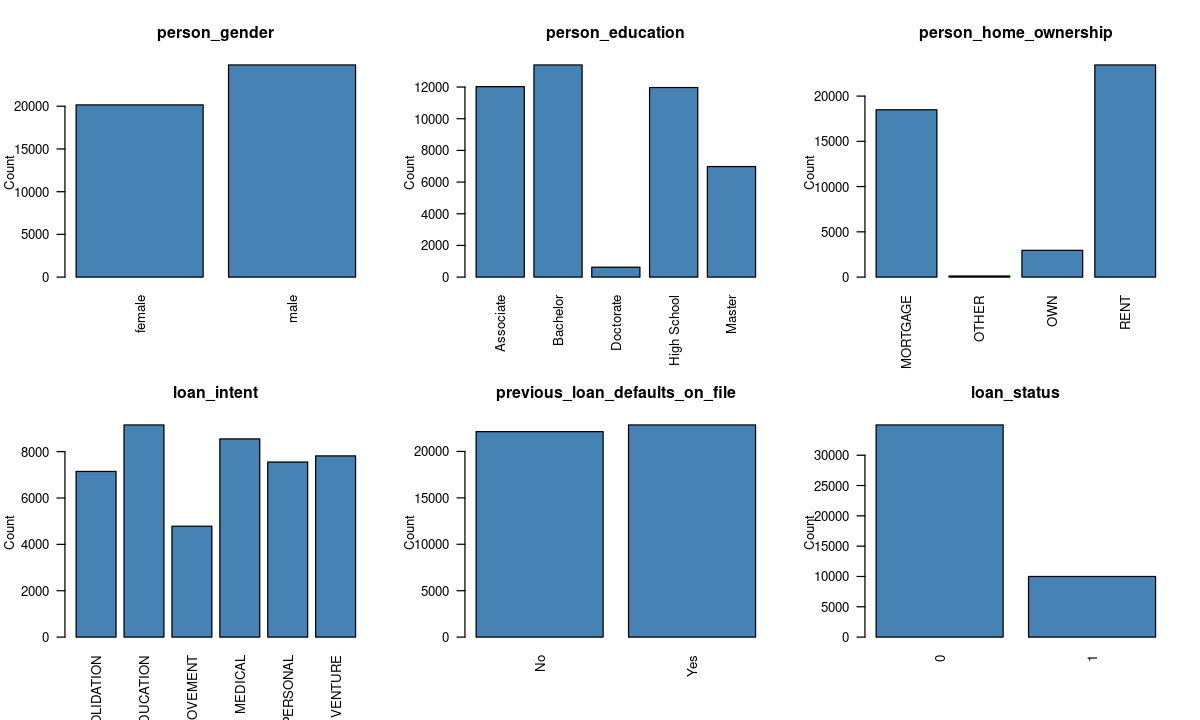

In [17]:
par(mfrow=c(2,3))
I = 6
for (i in 1:I) {
    plot(loan_quali[,i], main = colnames(loan_quali)[i],
         ylab = "Count", col="steelblue", las = 2)
    }


In [11]:
res.mca <- MCA(loan_quali, quali.sup = 6, graph = FALSE) #POUR LES VARIABLES QUALITATIVES

On garde 7 dims (1/p)

In [ ]:
fviz_mca_biplot(res.mca, 
                invisible = "ind", 
                repel = TRUE,     # empêche les textes de se chevaucher
                ggtheme = theme_minimal())

In [ ]:
p1 <- fviz_mca_ind(res.mca, label = "none", habillage = "loan_status")
p2 <- fviz_mca_ind(res.mca, label = "none", habillage = "loan_intent")
p3 <- fviz_mca_ind(res.mca, label = "none", habillage = "person_home_ownership")
p4 <- fviz_mca_ind(res.mca, label = "none", habillage = "previous_loan_defaults_on_file")

# Combine 4 plots in a 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2)


In [ ]:
fviz_ellipses(res.mca, c("loan_status", "previous_loan_defaults_on_file"),
              geom = "point")

### Quality of representation

In [ ]:
fviz_mca_var(res.mca, col.var = "cos2",
             gradient.cols = c("blue", "yellow", "red"), 
             repel = TRUE )


# Cos2 of variable categories on Dim.1 and Dim.2
fviz_cos2(res.mca, choice = "var", axes = 1:2)

### Contribution to the dimensions

In [ ]:
## TO BE COMPLETED ##
# Color by cos2 values: quality on the individual map
fviz_mca_ind(res.mca, col.ind = "cos2",
             gradient.cols = c("blue", "yellow", "red"))


# Cos2 of individuals on Dim.1 and Dim.2
fviz_cos2(res.mca, choice="ind", axes=1:2)

In [ ]:
## TO BE COMPLETED ##
# Contributions to dimension 1
fviz_contrib(res.mca, choice="var", axes=1, top=20)

# Contributions to dimension 2
fviz_contrib(res.mca, choice="var", axes=2, top=20)

In [ ]:
fviz_mca_var(res.mca, col.var = "contrib",
             gradient.cols = c("blue", "yellow", "red"), 
             repel = TRUE)

In [ ]:
res.mca.sup.quanti = MCA(loan, ,quanti.sup = c(1,4,5,7,9,10,11,12), graph = FALSE) #POUR LES VARIABLES QUALITATIVES

In [ ]:
fviz_mca_var(res.mca.sup.quanti,
             repel = TRUE,
             col.var = "black",  # modalités actives en noir
             col.quanti.sup = "blue",  # variables quantitatives en bleu
             geom = c("point", "arrow"),  # flèches pour les quanti
             ggtheme = theme_minimal())

In [ ]:
res.mca.sup.quanti$quanti.sup$coord

In [ ]:
fviz_mca_var(res.mca.sup.quanti, 
             choice = "quanti.sup", 
             repel = TRUE,
             col.var = "blue",
             ggtheme = theme_minimal())

In [ ]:
fviz_mca_var(res.mca.sup.quanti, axes = c(1, 3),
             col.var = "black",
             col.quanti.sup = "blue",
             geom = c("point", "arrow"),
             repel = TRUE)

In [ ]:
fviz_mca_var(res.mca.sup.quanti, axes = c(3,4),
             choice = "quanti.sup", 
             repel = TRUE,
             col.var = "blue",
             ggtheme = theme_minimal())

In [ ]:
res.mca.sup = MCA(loan, ,quanti.sup = c(1,4,5,7,9,10,11,12), quali.sup = c(13,14), graph = FALSE) #POUR LES VARIABLES QUALITATIVES


In [ ]:
fviz_mca_var(res.mca.sup,
             col.var = "black",             # modalités actives
             col.quali.sup = "red",         # modalités supplémentaires
             repel = TRUE,
             ggtheme = theme_minimal())

In [ ]:
fviz_mca_var(res.mca.sup,
             col.var = "black",             # modalités actives
             col.quali.sup = "red",         # modalités supplémentaires en rouge
             repel = TRUE,
             ggtheme = theme_minimal())

# MFA


In [12]:
loan_mfa <- data.frame(loan_quanti, loan_quali)
res.mfa <- MFA(
  loan_mfa,
  group = c(8, 6),     # Nombre de variables par groupe
  type = c("s", "n"),# "s" = quanti, "n" = quali
  name.group = c("Group_quanti", "Group_quali"),  # noms des groupes
  graph = FALSE
)

In [ ]:
fviz_screeplot(res.mfa, addlabels = TRUE)

In [ ]:
#fviz_mfa_ind(res.mfa, label = "none")
fviz_mfa_ind(res.mfa, label = "none", repel = TRUE)

In [ ]:
fviz_mfa_ind(res.mfa, label = "none",axes = c(1,3), repel = TRUE)

In [ ]:
fviz_mfa_ind(res.mfa, label = "none",axes = c(2,3), repel = TRUE)

In [ ]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$loan_status,
             addEllipses = TRUE,
             palette = "jco")

In [ ]:
fviz_mfa_ind(res.mfa,
             label = "none",axes = c(1,3),
             habillage = loan_quali$loan_status,
             addEllipses = TRUE,
             palette = "jco")

In [ ]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$person_education,
             addEllipses = TRUE,
             palette = "jco")

In [ ]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$person_home_ownership,
             addEllipses = TRUE,
             palette = "jco")

In [ ]:
fviz_mfa_ind(res.mfa,
             label = "none",
             habillage = loan_quali$previous_loan_defaults_on_file,
             addEllipses = TRUE,
             palette = "jco")

In [ ]:
fviz_mfa_var(res.mfa, "quanti.var", repel = TRUE,
             col.var = "contrib", gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

In [ ]:
fviz_mfa_var(res.mfa, "quali.var", repel = TRUE,
             col.var = "cos2", gradient.cols = c("lightblue", "blue", "darkblue"))

On trouve que dim2 permet de distinguer loan_status, de plus, les personnes qui possèdent leurs maison ou mortgage, qui ont un objectif d'emprunt pour l'education, ont un chance important pour avoir un emprunt. Les personnes qui ont un objectif de médicament, ou payent leur loyer ont une chance plus faibe pour avoir un emprunt.  

# Clustering

## K-means

In [ ]:
p1 = fviz_nbclust(loan_quanti, FUNcluster=stats::kmeans, method="wss") +
    ggtitle("WSS score")

grid.arrange(p1,p2,ncol=2)
# fviz_nbclust(...)

In [13]:
set.seed(123)
Kmax<- 5
reskmeanscl<-matrix(0,nrow=nrow(loan_quanti),ncol=Kmax-1)
Iintra<-NULL
for (k in 2:Kmax){
resaux<-kmeans(loan_quanti,k)
reskmeanscl[,k-1]<-resaux$cluster
Iintra<-c(Iintra,resaux$tot.withinss) #tot.withinss est l’inertie intra-classe totale
17
}
df<-data.frame(K=2:5,Iintra=Iintra)
Intrac <- ggplot(df,aes(x=K,y=Iintra)) + geom_line()+geom_point()+
xlab("NbClust") +ylab("Inertie intraclasse")


In [14]:
R2<-NULL
for (k in 2:Kmax){
resaux<-kmeans(loan_quanti,k)
reskmeanscl[,k-1]<-resaux$cluster
R2<-c(R2,resaux$betweenss/resaux$totss)
}
daux<-data.frame(NbClust=2:Kmax,R2=R2)
R2c <- ggplot(daux,aes(x=NbClust,y=R2))+geom_line()+geom_point()

In [24]:
library(clusterSim)
CH <- NULL
for (k in 2:Kmax){
CH<-c(CH,index.G1(loan_quanti,reskmeanscl[,k-1]))
}
daux<-data.frame(NbClust=2:Kmax,CH=CH)
CHc <- ggplot(daux,aes(x=NbClust,y=CH))+geom_line()+geom_point()

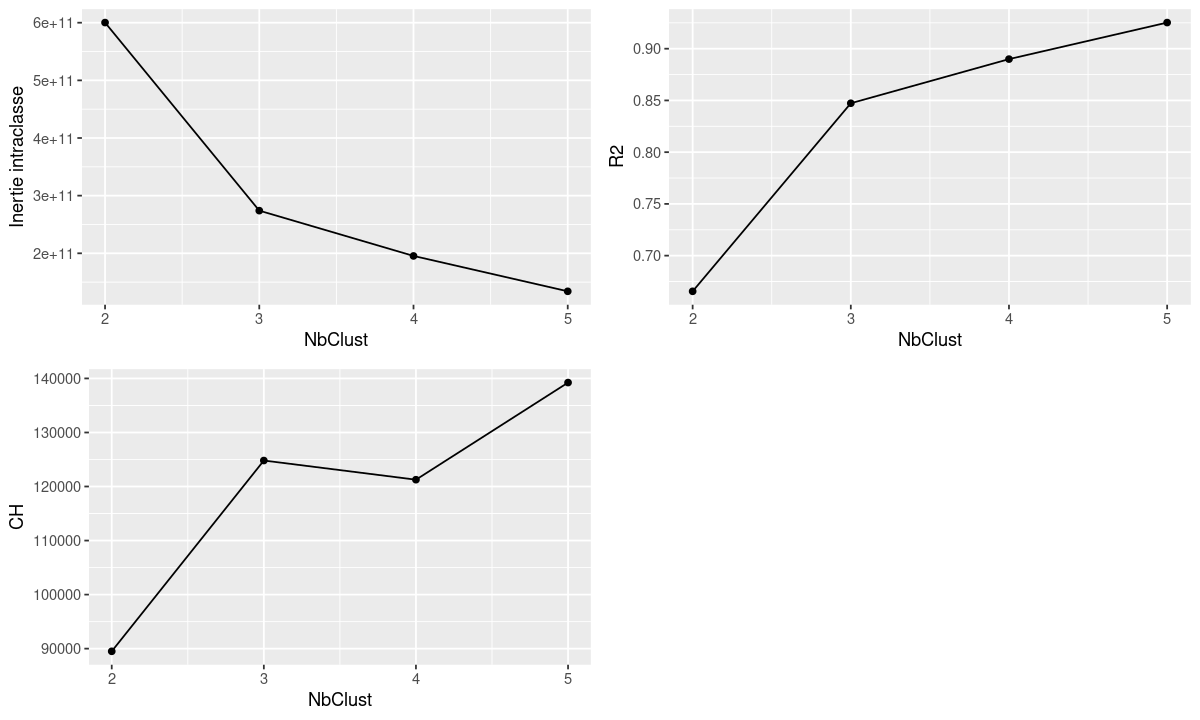

In [16]:
grid.arrange(Intrac,R2c,CHc, ncol = 2,nrow = 2)

In [17]:
reskmeans = kmeans(loan_quanti, centers=3) 

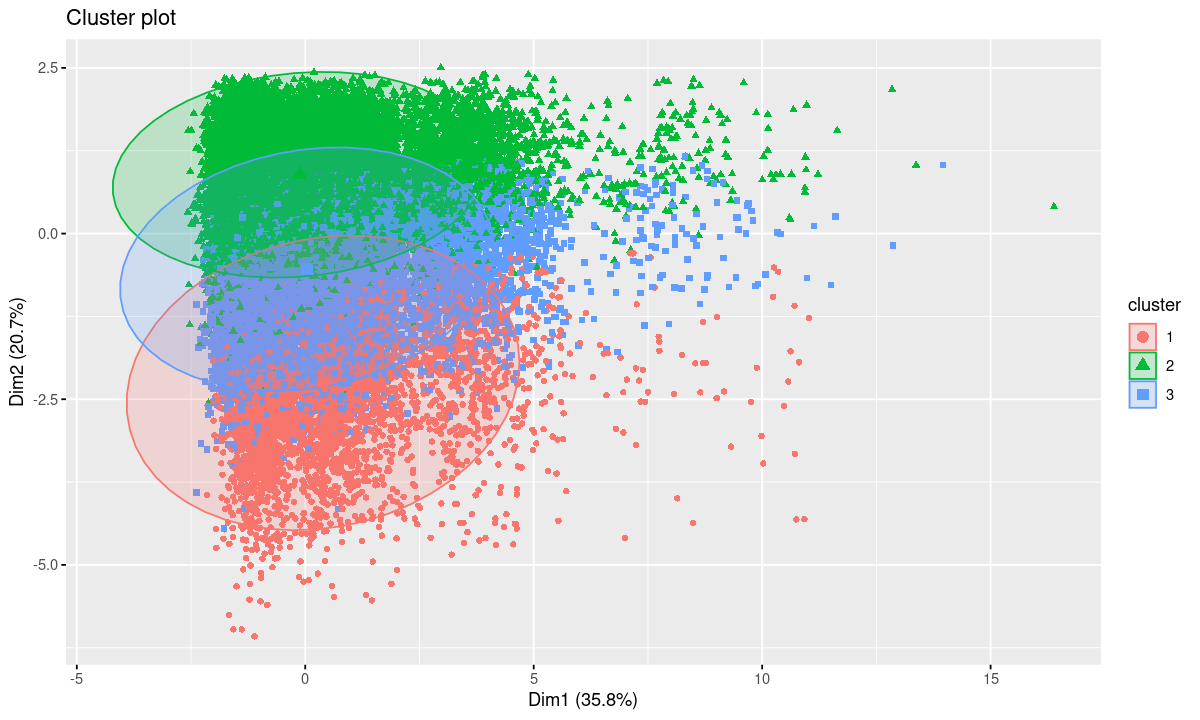

In [18]:
fviz_cluster(reskmeans, data=loan_quanti, ellipse.type="norm", labelsize=8, geom=c("point"))

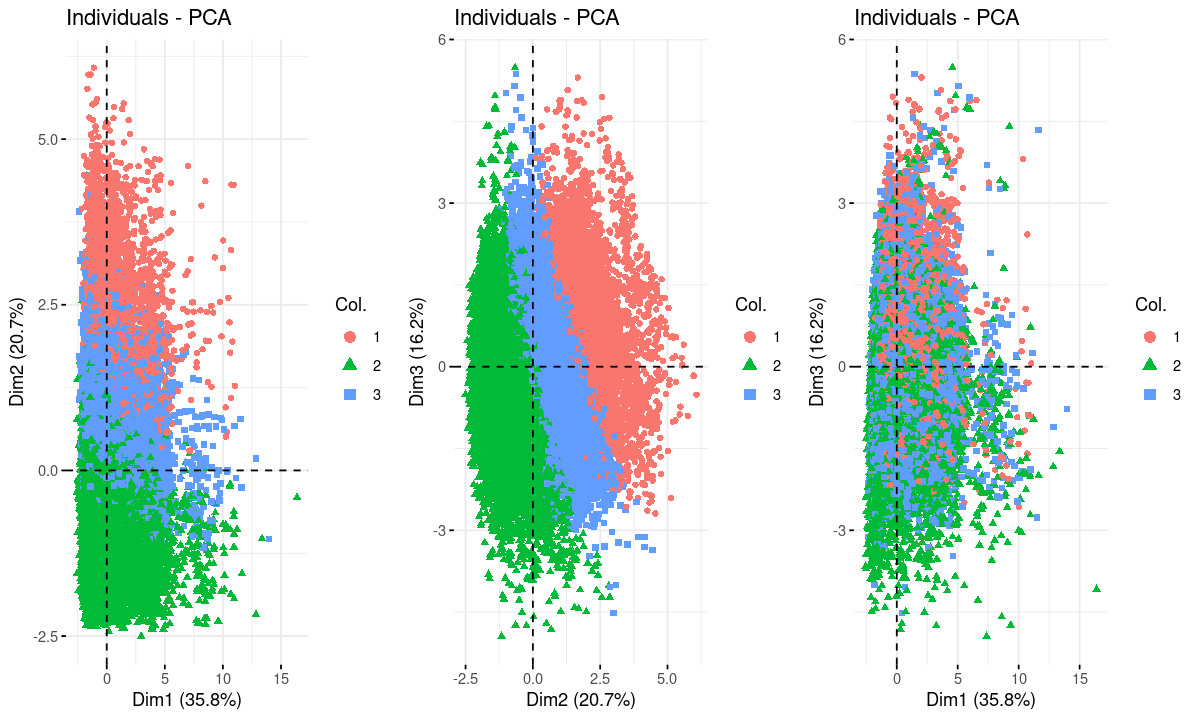

In [19]:
P1 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(1,2))
P2 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(2,3))
P3 <- fviz_pca_ind(acp,col.ind=as.factor(reskmeans$cluster),geom =c("point"),axes = c(1,3))
grid.arrange(P1,P2, P3, ncol = 3)

   
        1     2     3
  0  3677 19126 12190
  1  1871  4511  3618


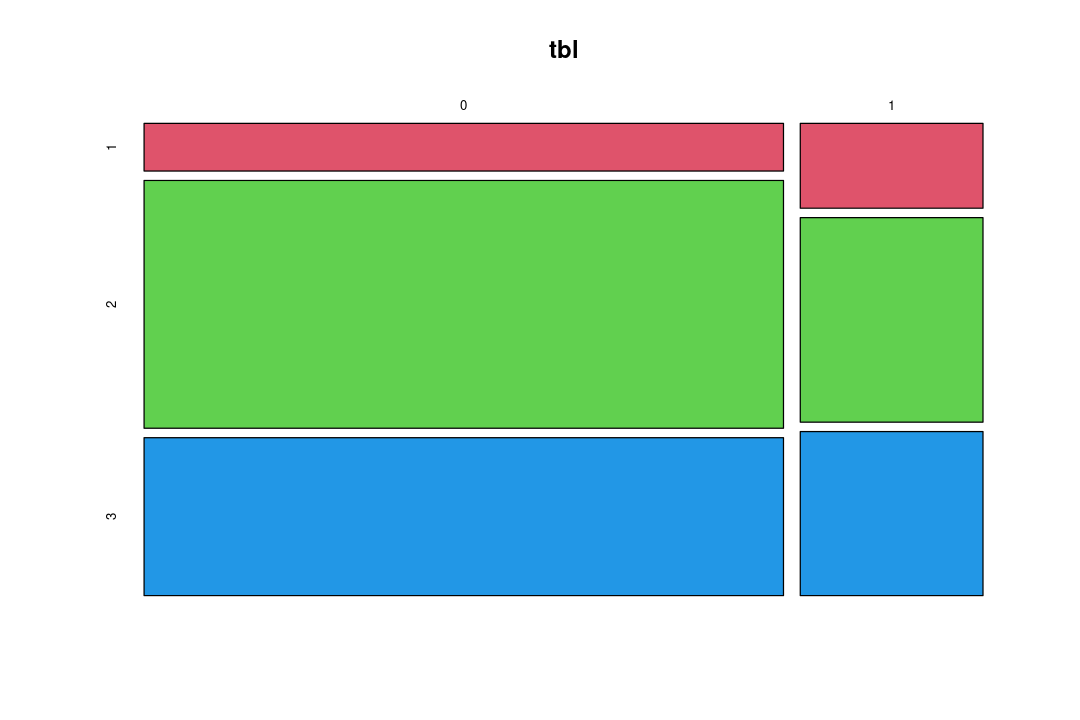

In [20]:
tbl = table(loan$loan_status, reskmeans$cluster)
print(tbl)

options(repr.plot.width = 9, repr.plot.height = 6)
mosaicplot(tbl, color=c(2:4))

# --- #
options(repr.plot.width = 15, repr.plot.height = 6)



## Gaussian Mixture

In [23]:
resBICall = mclustBIC(loan_quanti, G=2:5)


In [25]:
summary(resBICall)

Best BIC values:
            VVV,5       EVV,5       VVV,4
BIC      -2042918 -2056656.00 -2062841.96
BIC diff        0   -13737.98   -19923.95

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


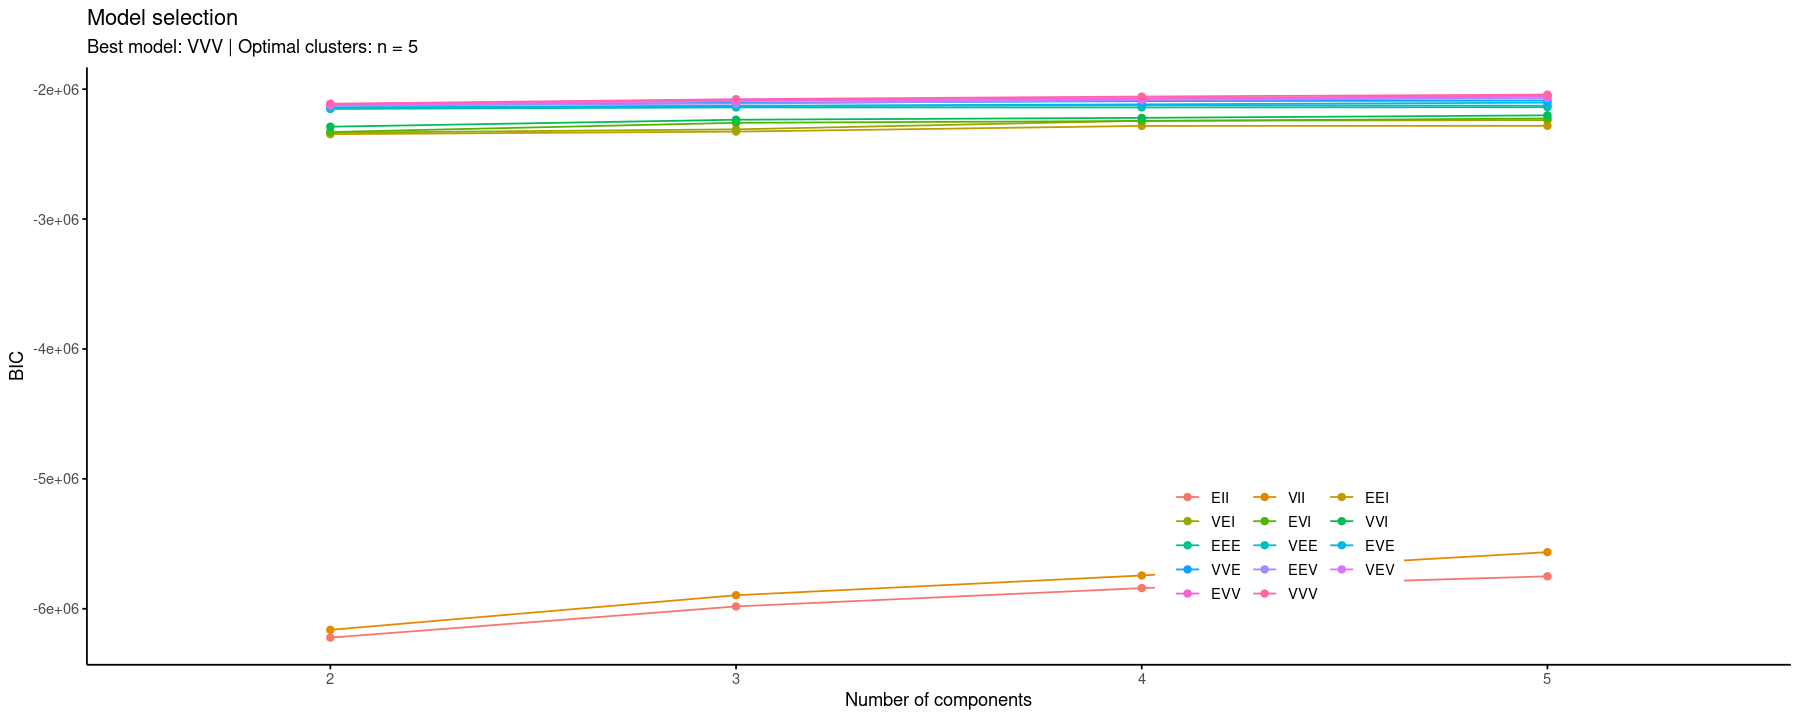

In [26]:
resBICall = Mclust(loan_quanti, G=2:5)
fviz_mclust(resBICall, what="BIC")

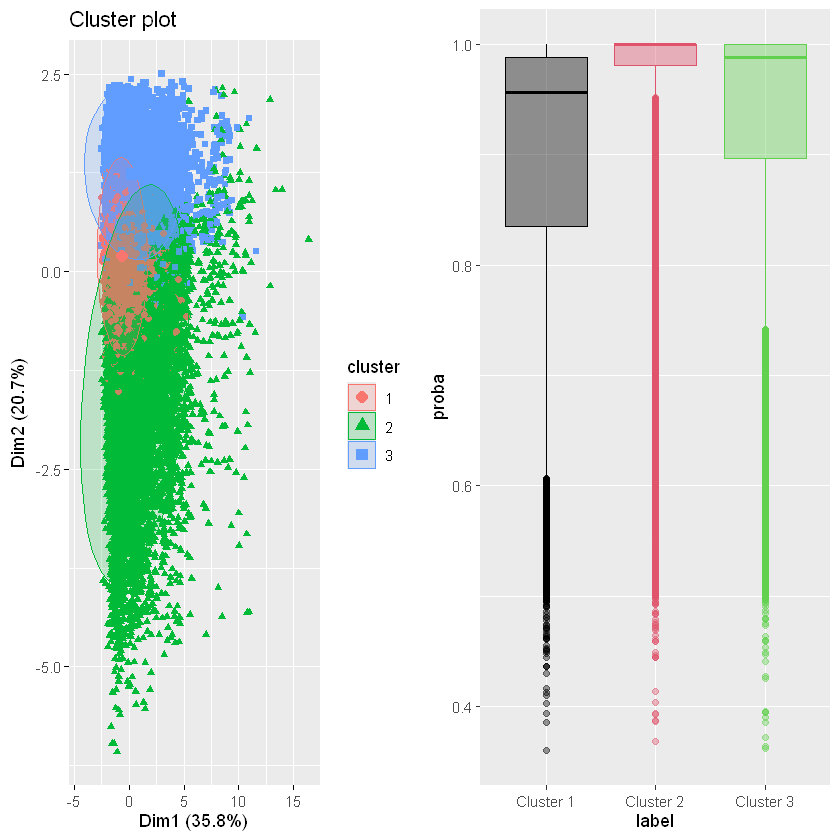

In [59]:
K = 3
gmm = Mclust(loan_quanti, G=K)
p1 = fviz_cluster(gmm, data = loan_quanti, ellipse.type="norm", geom="point")

aux = data.frame(label = paste("Cluster",gmm$classification, sep = " "),
                 proba = apply(gmm$z, 1, max))

p2 = ggplot(aux, aes(x=label, y = proba)) + geom_boxplot(colour = 1:K, fill=1:K, alpha =  0.4)
grid.arrange(p1,p2,ncol = 2)

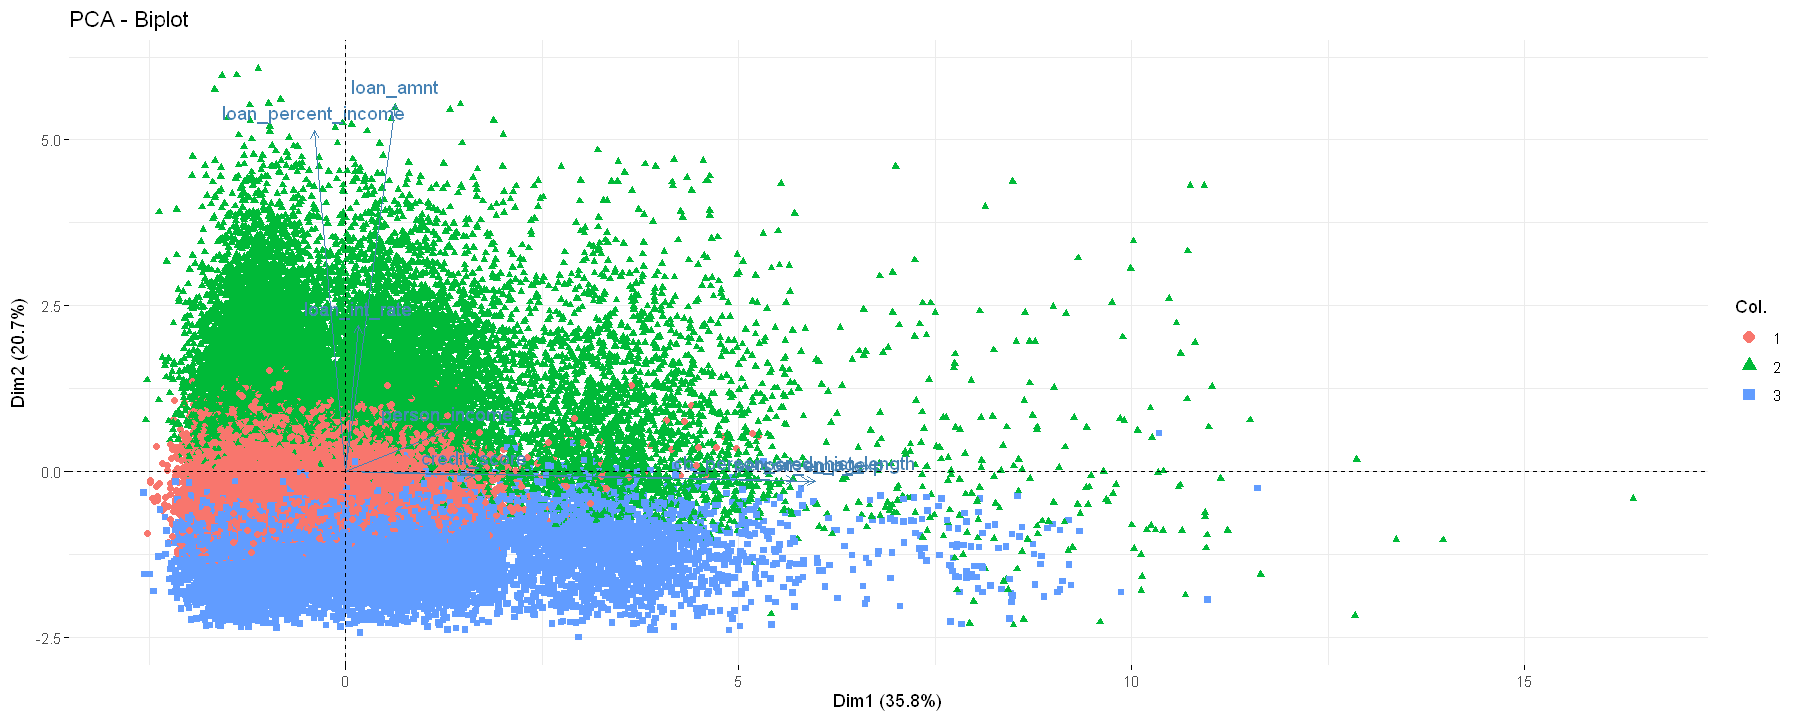

In [74]:
fviz_pca(acp, axes = c(1,2), geom = c("point"), col.ind = as.factor(gmm$classification))

### Spectral clustering

In [29]:
# Encodage one-hot pour toutes les variables qualitatives
loan_matrix <- model.matrix(~ . -1, data = loan)
loan_matrix <- scale(loan_matrix)

In [ ]:
set.seed(123)
sc_res <- specc(loan_matrix, centers = 3)
fviz_pca(acp, axes = c(1,2), geom = c("point"), col.ind = as.factor(sc_res))

In [ ]:
## LDA

In [ ]:
loan_matrix <- model.matrix(loan_status ~ . -1, data = loan)
lda_model <- lda(loan$loan_status ~ ., data = as.data.frame(loan_matrix))
lda_coords <- predict(lda_model)$x

df_lda <- data.frame(lda_coords, loan_status = loan$loan_status)
ggplot(df_lda, aes(x = LD1, y = LD2, color = loan_status)) +
  geom_point(alpha = 0.5) +
  labs(title = "Projection LDA selon loan_status") +
  theme_minimal()

In [ ]:
loan_matrix <- model.matrix(~ . -1, data = loan)
loan_matrix <- as.data.frame(loan_matrix)

In [ ]:

res.nmf <- nmf(as.matrix(loan_matrix), rank = 2, nrun = 10, seed = 123)

# Visualiser les profils
basis(res.nmf)      # matrice W (individus)
coef(res.nmf)       # matrice H (composantes)